# Projet 7 - Prédictions

In [1]:
# Librairies de base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn

# Echantillonnage
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# MLFlow
import mlflow
from mlflow import MlflowClient
from mlflow.tracking import MlflowClient

# Sklearn
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, fbeta_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score,\
f1_score, roc_auc_score, roc_curve, fbeta_score, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA

# Modèles de classification
import lightgbm as lgb
from catboost import CatBoostClassifier
from catboost import Pool
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Autres
import shap # Feature importance
import importlib
from evidently import ColumnMapping
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

In [2]:
!python --version

# Version des bibliothèques utilisées (standard)
print('\n'.join(f'{m.__name__} - {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))


# Version des bibliothèques utilisées (import non complet)
print("matplotlib - ", importlib.metadata.version('matplotlib'))
print("catboost - ", importlib.metadata.version('catboost'))
print("xgboost - ", importlib.metadata.version('xgboost'))

Python 3.11.10
pandas - 2.2.2
numpy - 1.26.4
imblearn - 0.12.3
mlflow - 2.16.2
sklearn - 1.5.2
lightgbm - 4.5.0
shap - 0.45.1
matplotlib -  3.9.2
catboost -  1.2.7
xgboost -  2.1.1


- Objectifs :
    - minimiser les faux négatifs (métrique = recall le plus élevé possible)
    - minimiser les faux positifs (métrique = precision le plus élevé possible)
- Déséquilibres dans le jeu de données : trop de bons clients (0) par rapport aux mauvais clients (1) --> utiliser l'argument class_weight pour résoudre le pb ds la mise en place des modèles

In [4]:
# Création de l'expérience MLFlow

client = MlflowClient(tracking_uri="http://127.0.0.1:8080")
mlflow.set_tracking_uri("http://127.0.0.1:8080")
all_experiments = client.search_experiments()
print(all_experiments)

# Provide an Experiment description that will appear in the UI
#experiment_description = ("Classification des clients projet 7")

# Tag de l'expérience
#experiment_tags = {
#    "project_name": "Projet_7",
#    "mlflow.note.content": experiment_description,
#}

# Create the Experiment, providing a unique name
#projet_7_experiment = client.create_experiment(
#    name="Projet_7", tags=experiment_tags
#)

# returns the Experiment metadata
projet_7_experiment_current = mlflow.set_experiment("Projet_7")
mlflow.set_experiment("Projet_7")
# Define an artifact path that the model will be saved to.
artifact_path = "Projet_7"


[<Experiment: artifact_location='mlflow-artifacts:/968375300374959334', creation_time=1726734944017, experiment_id='968375300374959334', last_update_time=1726734944017, lifecycle_stage='active', name='Projet_7', tags={'mlflow.note.content': 'Classification des clients projet 7',
 'project_name': 'Projet_7'}>, <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1726734880999, experiment_id='0', last_update_time=1726734880999, lifecycle_stage='active', name='Default', tags={}>]


## Préparation des données

In [5]:
# Importation de la data

application_train_preprocessed = pd.read_csv("../data/application_train_preprocessed.csv")


In [6]:
display(application_train_preprocessed)

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,False,False,False,False,True,False,True,False,1,False
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,False,False,False,False,False,False,True,False,0,False
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,False,False,False,False,False,False,False,False,0,False
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,False,False,False,False,False,False,False,False,0,False
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,False,False,False,False,False,False,False,False,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,0,0,157500.0,254700.0,27558.0,225000.0,0.032561,...,False,False,False,False,True,False,True,False,0,False
307507,456252,0,0,1,0,72000.0,269550.0,12001.5,225000.0,0.025164,...,False,False,False,False,True,False,True,False,0,True
307508,456253,0,0,1,0,153000.0,677664.0,29979.0,585000.0,0.005002,...,False,False,False,True,False,False,True,False,0,False
307509,456254,0,0,1,0,171000.0,370107.0,20205.0,319500.0,0.005313,...,False,False,False,False,True,False,True,False,1,False


In [7]:
# Split train/test

X = application_train_preprocessed.drop('TARGET', axis=1)
y = application_train_preprocessed['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

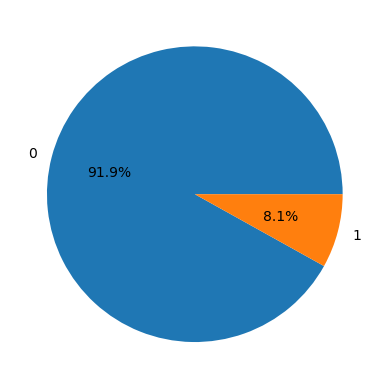

In [8]:
target_counts = y_train.value_counts()
plt.pie(target_counts, labels=['0', '1'], autopct='%1.1f%%')
plt.show()

In [9]:
 # Extraction du nom des variables
features = list(X.columns)

# Imputation valeurs manquantes par la médiane
imputer = SimpleImputer(strategy = 'median')
imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

# Suréchantillonnage avec SMOTE
#smote = SMOTE(random_state=42)
#X_train, y_train = smote.fit_resample(X_train, y_train)

# Sous échantillonnage avec RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.4, random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

# Normalisation avec MinMaxScaler, plus adapté que Standard Scaler
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

"""REDUCTION DIMENSIONS AVEC PCA"""

# Application de la PCA
#pca = PCA()
#X_pca = pca.fit_transform(X_train)

# Calcul de la variance expliquée cumulée
#explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Graphique de la variance expliquée cumulée
#plt.figure(figsize=(10, 6))
#plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
#plt.xlabel('Number of Components')
#plt.ylabel('Cumulative Explained Variance')
#plt.title('PCA: Cumulative Explained Variance')
#plt.xticks(np.arange(0, len(explained_variance) + 1, step=10))
#plt.grid(True)
#plt.show()

'REDUCTION DIMENSIONS AVEC PCA'

In [10]:
# Suite de la PCA

# Choix du seuil de variance expliquée
#threshold = 0.98
#n_components = np.argmax(explained_variance >= threshold) + 1
#print("Nombre de composantes :", n_components)

# Application PCA sur les données d'entraînement et de test
#pca = PCA(n_components=n_components)
#X_train = pca.fit_transform(X_train)
#X_test = pca.transform(X_test)

In [11]:
# Mise en forme dataframe

X_train = pd.DataFrame(X_train, columns=features)
X_test = pd.DataFrame(X_test, columns=features)

X_train.columns = X_train.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)

print('Training data shape: ', X_train.shape)
print('Testing data shape: ', X_test.shape)

Training data shape:  (69566, 240)
Testing data shape:  (61503, 240)


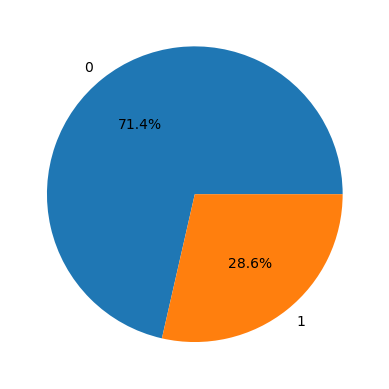

In [12]:
target_counts = y_train.value_counts()
plt.pie(target_counts, labels=['0', '1'], autopct='%1.1f%%')
plt.show()

## Mise en place des fonctions modèle et résultats

In [13]:
#auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
#precision_scorer = make_scorer(precision_score)

# Modèle
def entrainementModeleAvecCV(modele, arguments_modele, param_grid, beta, save_model=False):
    modele = modele(**arguments_modele) # argument class_weight pour gérer déséquilibre des données
    f_beta_scorer = make_scorer(fbeta_score, beta=beta)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    """CROSS VALIDATION GRID SEARCH"""
    
    #grid_search = GridSearchCV(estimator=modele,
                               #param_grid=param_grid,
                               #scoring=f_beta_scorer,
                               #cv=cv,
                               #verbose=0,
                               #n_jobs=-1)

    #grid_search.fit(X_train, y_train)

    """CROSS VALIDATION RANDOMIZED"""
    
    n_iter_search = 50

    grid_search = RandomizedSearchCV(estimator=modele,
                                       param_distributions=param_grid, 
                                       scoring=f_beta_scorer,
                                       cv=cv,
                                       verbose=0,
                                       n_jobs=-1,
                                       n_iter=n_iter_search,
                                       random_state=42)

    grid_search.fit(X_train, y_train)
    
    """SAUVEGARDE MEILLEUR MODELE"""
    
    meilleurModele = grid_search.best_estimator_
    print("Meilleurs paramètres trouvés :", grid_search.best_params_)
    print("Meilleur score F-bêta :", grid_search.best_score_)
    
    #Sauvegarde du modèle
    if save_model:
        meilleurModele.save_model(f'{modele}.cbm')
        
    """PREDICTIONS TRAIN"""

    model_pred_proba_train = meilleurModele.predict_proba(X_train)[:, 1]
    model_pred_train = meilleurModele.predict(X_train)

    """PREDICTIONS TEST"""
    
    model_pred_proba = meilleurModele.predict_proba(X_test)[:, 1]
    model_pred = meilleurModele.predict(X_test)

    return {
        "modele":modele,
        "hyperparametres": meilleurModele,
        "model_pred_proba": model_pred_proba,
        "model_pred": model_pred,
        "model_pred_proba_train": model_pred_proba_train,
        "model_pred_train":model_pred_train,
    }
    
# Entrainement sur le jeu de train
#log_reg.fit(X_train, y_train)

In [14]:
# Mise en place de la fonction de coût

# Définir les coûts
cout_faux_positif = 1
cout_faux_negatif = 10

# Fonction de coût
def calculer_cout(y_test, probas, seuil):
    predictions = (probas > seuil).astype(int)
    cm = confusion_matrix(y_test, predictions)
    _, fp, fn, _ = cm.ravel()
    return (fp * cout_faux_positif) + (fn * cout_faux_negatif)


In [15]:
def affichageResultatsModele(model_dict, feat_importance=True):

    model_pred = model_dict["model_pred"]
    model_pred_proba = model_dict["model_pred_proba"]
    model_pred_train = model_dict["model_pred_train"]
    model_pred_proba_train = model_dict["model_pred_proba_train"]
    hyperparametres = model_dict["hyperparametres"]
    hyperparametres_dict = model_dict["hyperparametres"].get_params()

    print("JEU ENTRAINEMENT :")  

    """MATRICE DE CONFUSION TRAIN SANS FONCTION METIER"""

    print("Matrice de confusion train sans fonction métier (seuil = 0.5) :")
    cm_optimal_train = confusion_matrix(y_train, model_pred_train)    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_optimal_train)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap='Blues', colorbar=False, values_format='')
        
    plt.xlabel('Prédiction')
    plt.ylabel('Vérité terrain')
    plt.title('Matrice de Confusion')
    plt.show()

    """METRIQUES TRAIN"""
    
    precision_train = round(precision_score(y_train, model_pred_train), 4)
    recall_train = round(recall_score(y_train, model_pred_train), 4)
    f1_train = round(f1_score(y_train, model_pred_train), 4)
    roc_auc_train = round(roc_auc_score(y_train, model_pred_train), 4)
    #f1_beta = round(fbeta_score(y_test, model_pred, beta = beta), 4)
    
    metrics_train = {"precision":precision_train, "recall":recall_train, "f1":f1_train, "roc_auc":roc_auc_train}
    display(metrics_train)
    
    """SEUIL OPTIMAL TRAIN"""
    
    print("Matrice de confusion train avec fonction métier :")

    # Calculer les coûts pour une gamme de seuils
    seuils = np.arange(0, 1, 0.1)
    couts_train = [calculer_cout(y_train, model_pred_proba_train, seuil) for seuil in seuils]
    plt.figure(figsize=(8, 6))
    plt.plot(seuils, couts_train, marker='o', linestyle='-', color='b')
    plt.xlabel('Seuils')
    plt.ylabel('Coûts')
    plt.title('Évolution des coûts en fonction des seuils')
    plt.grid(True)
    
    # Trouver le seuil optimal
    seuil_optimal_train = seuils[np.argmin(couts_train)]
    
    model_pred_classes_train = (model_pred_proba_train > seuil_optimal_train).astype(int)  
    
    """MATRICE DE CONFUSION TRAIN AVEC FONCTION METIER"""

    print("Seuil optimal trouvé :",round(seuil_optimal_train,4))
    cm_optimal_train = confusion_matrix(y_train, model_pred_classes_train)    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_optimal_train)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap='Blues', colorbar=False, values_format='')
        
    plt.xlabel('Prédiction')
    plt.ylabel('Vérité terrain')
    plt.title('Matrice de Confusion')
    plt.show()
    
    print("JEU DE TEST :")

    """MATRICE DE CONFUSION TEST SANS FONCTION METIER"""

    print("Matrice de confusion sans fonction métier (seuil = 0.5) :")
    cm_optimal = confusion_matrix(y_test, model_pred)    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_optimal)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap='Blues', colorbar=False, values_format='')
        
    plt.xlabel('Prédiction')
    plt.ylabel('Vérité terrain')
    plt.title('Matrice de Confusion')
    plt.show()

    """METRIQUES"""
    precision = round(precision_score(y_test, model_pred), 4)
    recall = round(recall_score(y_test, model_pred), 4)
    f1 = round(f1_score(y_test, model_pred), 4)
    roc_auc = round(roc_auc_score(y_test, model_pred_proba), 4)
    #f1_beta = round(fbeta_score(y_test, model_pred, beta = beta), 4)
    
    metrics = {"precision":precision, "recall":recall, "f1":f1, "roc_auc":roc_auc}
    display(metrics)
    
    """SEUIL OPTIMAL TEST"""
    
    print("Matrice de confusion avec fonction métier :")
    
    # Calculer les coûts pour une gamme de seuils
    couts = [calculer_cout(y_test, model_pred_proba, seuil) for seuil in seuils]
    plt.figure(figsize=(8, 6))
    plt.plot(seuils, couts, marker='o', linestyle='-', color='b')
    plt.xlabel('Seuils')
    plt.ylabel('Coûts')
    plt.title('Évolution des coûts en fonction des seuils')
    plt.grid(True)
    
    # Trouver le seuil optimal
    seuil_optimal = seuils[np.argmin(couts)]
    np.save('seuil_optimal.npy', seuil_optimal)
    
    model_pred_classes = (model_pred_proba > seuil_optimal).astype(int)
    
    """MATRICE DE CONFUSION TEST AVEC FONCTION METIER"""

    print("Seuil optimal trouvé :",round(seuil_optimal,4))
    cm_optimal = confusion_matrix(y_test, model_pred_classes)    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_optimal)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap='Blues', colorbar=False, values_format='')
        
    plt.xlabel('Prédiction')
    plt.ylabel('Vérité terrain')
    plt.title('Matrice de Confusion')
    plt.show()

    """FEATURE IMPORTANCE GLOBALE"""
    if feat_importance:
        explainer = shap.Explainer(hyperparametres, X_train)
        shap_values = explainer(X_test)
        shap.summary_plot(shap_values, X_test)

    """ENVOI DANS LE MLFLOW"""
    with mlflow.start_run() as run:
        mlflow.set_tag("model_name", type(hyperparametres).__name__) #nom du modèle
        mlflow.log_params(hyperparametres_dict) #hyperparametres du modèle
        mlflow.log_metrics(metrics) #metriques du modele    
        mlflow.sklearn.log_model(sk_model=hyperparametres, artifact_path="Projet_7")

In [16]:
def featImpLoc(modele, individu):
    # Créer un Pool à partir des données de test pour l'échantillon spécifié
    data_pool = Pool(data=X_test.iloc[[individu]], feature_names=X_test.columns.tolist())
    
    # Calculer l'importance des caractéristiques locales pour un échantillon
    modeleEntraine = modele["hyperparametres"]
    feature_importances = modeleEntraine.get_feature_importance(data=data_pool, type='ShapValues')

    # Extraire et préparer les données pour la visualisation
    features = X_test.columns
    importance_values = feature_importances[0][1:]  # On enlève la valeur de base
    sorted_idx = np.argsort(importance_values)[::-1]  # Tri décroissant
    
    # Sélectionner les 20 caractéristiques les plus importantes
    top_n = 20
    top_idx = sorted_idx[:top_n]
    top_features = features[top_idx]
    top_importance_values = importance_values[top_idx]
    
    # Afficher les importances
    plt.figure(figsize=(10, 6))
    plt.barh(top_features, top_importance_values)
    plt.xlabel('Importance')
    plt.title(f'20 features les plus significatives pour l\'individu {individu}')
    plt.show()

## Test de différents modèles

#### LogisticRegression

In [ ]:
arguments_modele={}

param_grid = {
    "C": [10, 15, 17],
    "max_iter": [200, 300, 400]
}

LogisticRegression_entraine = entrainementModeleAvecCV(LogisticRegression, arguments_modele, param_grid, 2)
affichageResultatsModele(LogisticRegression_entraine, False)

#### LightGBM Classifier

In [ ]:
arguments_modele={}

param_grid = {
    "num_leaves":[31, 63, 127],
    "n_estimators":[100,200],
    "max_depth":[3,5],
}

LGBMClassifier_entraine = entrainementModeleAvecCV(lgb.LGBMClassifier, arguments_modele, param_grid, 2)
affichageResultatsModele(LGBMClassifier_entraine, False)

#### Catboost Classifier

Meilleurs paramètres trouvés : {'verbose': False, 'n_estimators': 1100, 'learning_rate': 0.15, 'l2_leaf_reg': 10, 'early_stopping_rounds': 50, 'depth': 7}
Meilleur score F-bêta : 0.3887883212676105
JEU ENTRAINEMENT :
Matrice de confusion train sans fonction métier (seuil = 0.5) :


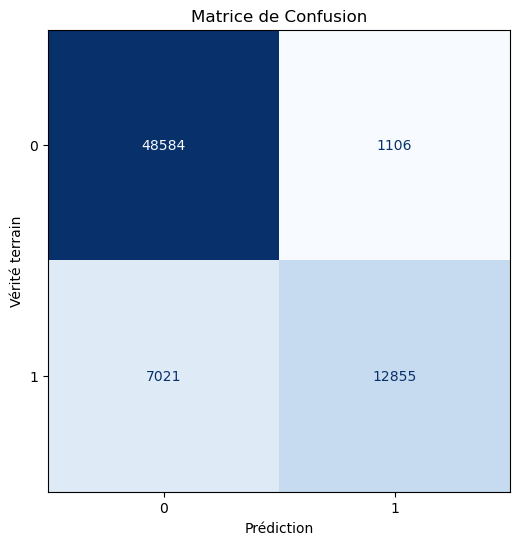

{'precision': 0.9208, 'recall': 0.6468, 'f1': 0.7598, 'roc_auc': 0.8123}

Matrice de confusion train avec fonction métier :
Seuil optimal trouvé : 0.2


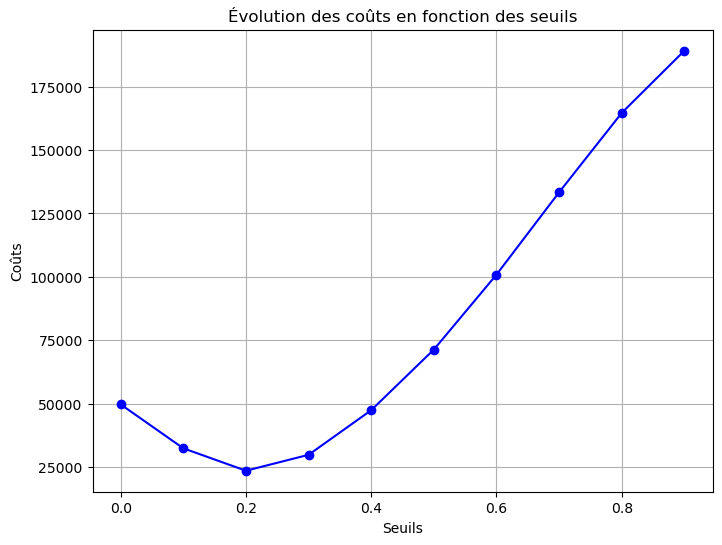

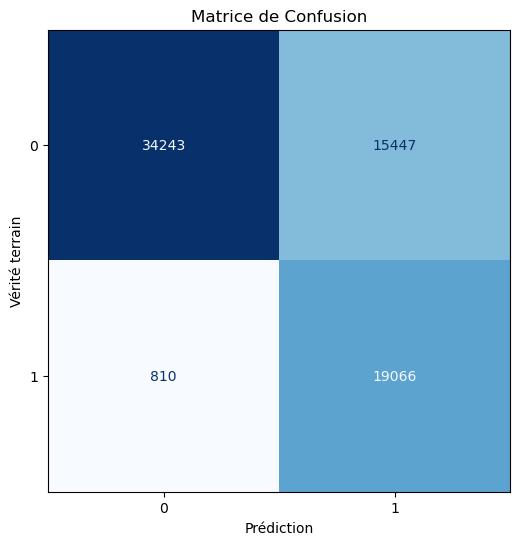

JEU DE TEST :
Matrice de confusion sans fonction métier (seuil = 0.5) :


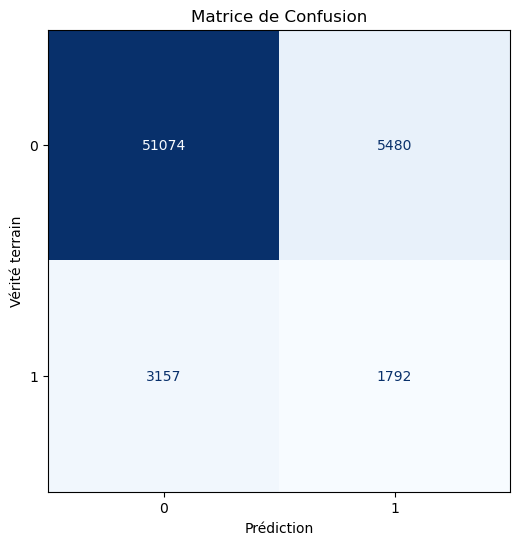

{'precision': 0.2464, 'recall': 0.3621, 'f1': 0.2933, 'roc_auc': 0.7485}

Matrice de confusion avec fonction métier :
Seuil optimal trouvé : 0.3


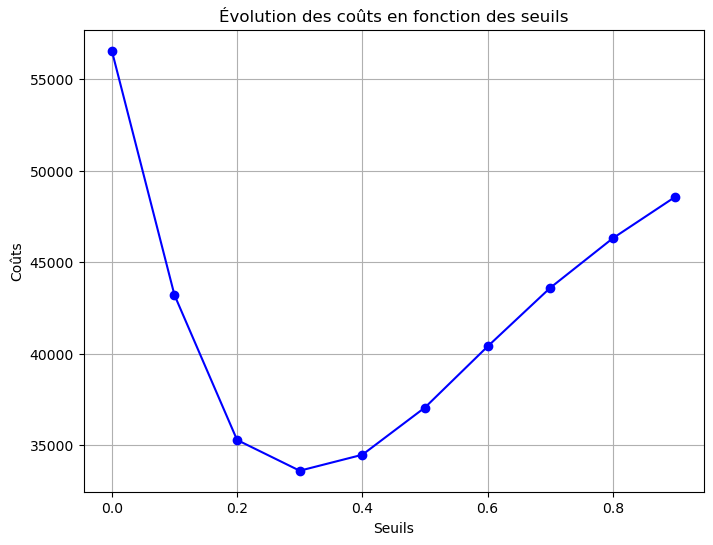

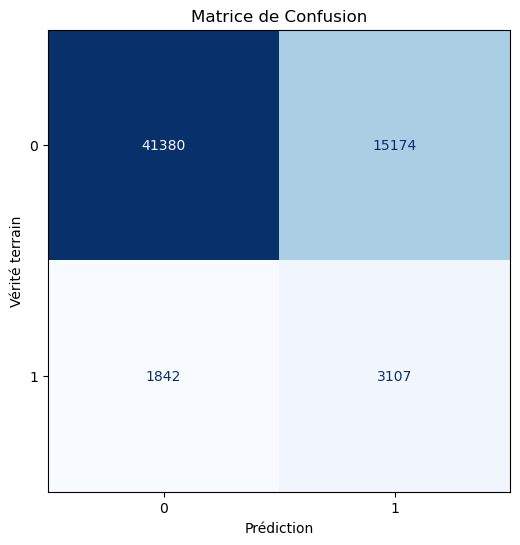

100%|===================| 61497/61503 [72:30<00:00]        

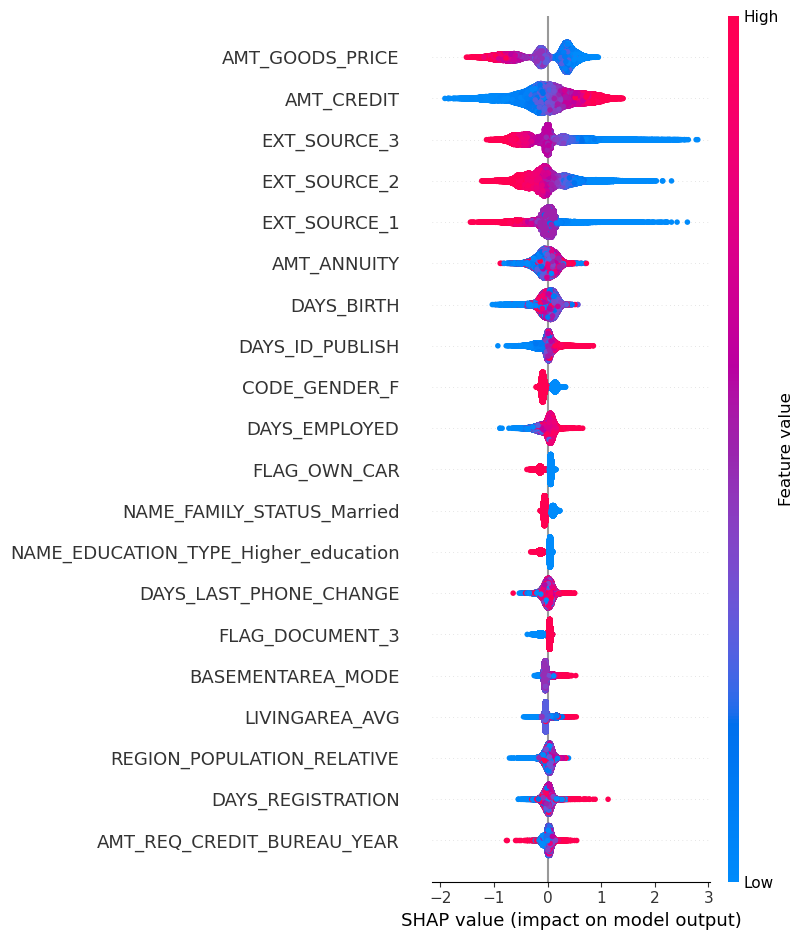

2024/10/18 13:23:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/18 13:23:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run rebellious-quail-12 at: http://127.0.0.1:8080/#/experiments/968375300374959334/runs/6e358985c7344a57a3f2c84a80c7a602.
2024/10/18 13:23:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/968375300374959334.


In [17]:
arguments_modele={}

param_grid = {
    'depth': [5,6,7],
    'learning_rate': [0.05,0.1,0.15],
    'n_estimators': [700,900,1100],
    'l2_leaf_reg':[6,8,10],
    'verbose':[False],
    'early_stopping_rounds':[50],
}

CatBoostClassifier_entraine = entrainementModeleAvecCV(CatBoostClassifier, arguments_modele, param_grid, 2)
affichageResultatsModele(CatBoostClassifier_entraine, True)

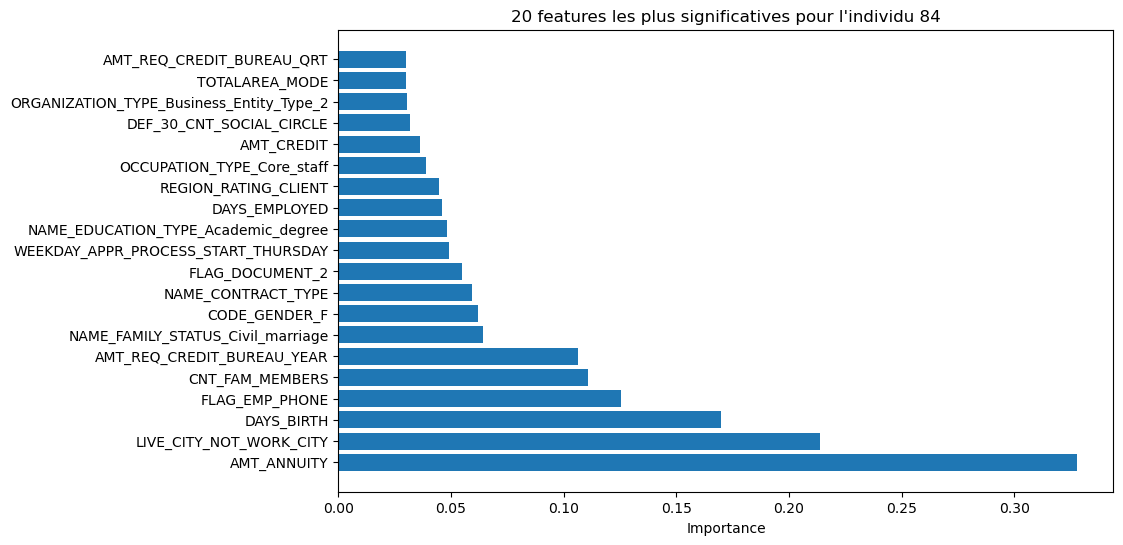

In [18]:
featImpLoc(CatBoostClassifier_entraine, 84)

#### XGBoost

In [ ]:
# XGBClassifier n'a pas de fonctionnalite intégrée pour équilibrer les classes
#class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
#class_weights_dict = dict(zip(np.unique(y_train), class_weights))
#scale_pos_weight = class_weights_dict[1] / class_weights_dict[0]

arguments_modele={}

param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'gamma':[0, 0.1, 0.2]
}

CatBoostClassifier_entraine = entrainementModeleAvecCV(XGBClassifier, arguments_modele, param_grid, 2)
affichageResultatsModele(CatBoostClassifier_entraine, False)

#### RandomForest

In [ ]:
arguments_modele={}

param_grid = {
    "n_estimators":[100,200,300],
    "max_depth":[2,3,4],
    "min_samples_split":[2,3,4],
    "min_samples_leaf":[1,2,3],
}

RandomForestClassifier_entraine = entrainementModeleAvecCV(RandomForestClassifier, arguments_modele, param_grid, 2)
affichageResultatsModele(RandomForestClassifier_entraine, False)

## Surveillance du data drift

In [ ]:
# Spécification des chemins d'accès relatifs
chemin_train = '../data/application_train.csv'
chemin_test = '../data/application_test.csv'

# Chargement des datasets
application_train = pd.read_csv(chemin_train)
application_train = application_train.drop(columns=['TARGET'])
application_test = pd.read_csv(chemin_test)

# Création du rapport de data drift
report = Report(metrics=[DataDriftPreset()])
report.run(reference_data=application_train, current_data=application_test)

# Génération et affichage du rapport HTML
report.save_html('data_drift_report.html')

